In [1]:
import os
import glob
import sys
import getpass
import importlib
from tqdm import tqdm
from pathlib import Path

# user path:
usrname = getpass.getuser()
# add paths:
sys.path.append(f'/Users/{usrname}/Desktop/Projects')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/bimanual_wrist')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/Functional_Fusion')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/PcmPy')


import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns

import scipy.stats as stats
import scipy
import scipy.io as sio
import numpy as np
import pandas as pd

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')



# Build dataset

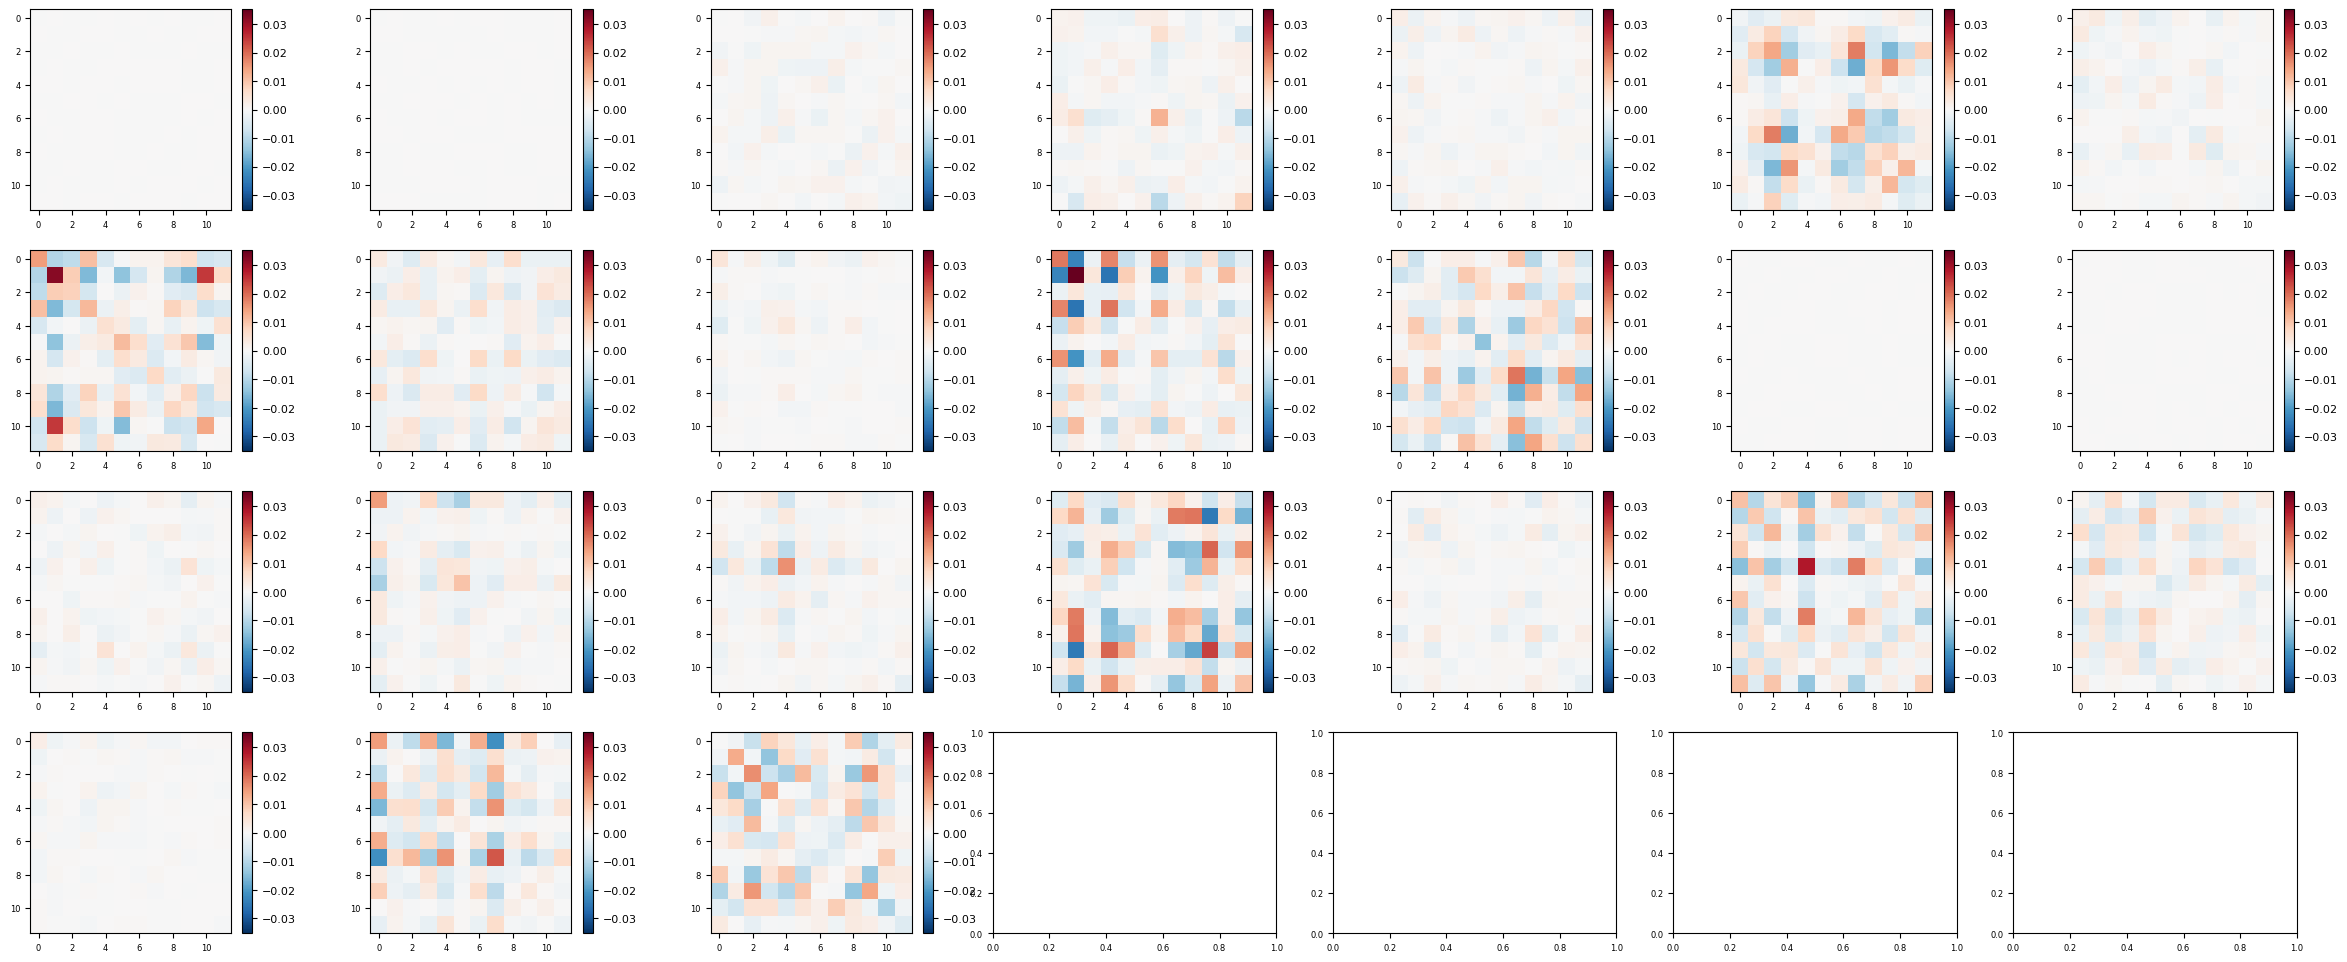

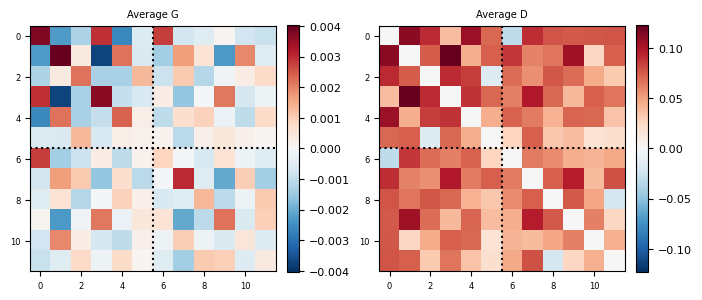

In [49]:
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn', 'flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
labels_lateral = ['contra']*6 + ['ipsi']*6
cmap = 'RdBu_r'
sn_bad = [102, 103]
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
hem = ['L','R']

region = regions[0]
data, cond_vec, part_vec = [], [], []
for i_hem, h in enumerate(hem):
    roi = f'{region}_{h}'
    file_path = os.path.join(analysisDir, f'pwbeta_{roi}.npz')
    d = np.load(file_path, allow_pickle=True)

    subject = d['subject']
    indices = [k for k, s in enumerate(subject) if s not in sn_bad]

    subject = d['subject'][indices]
    cond_name_tmp = d['cond_intrinsic_vec'][indices]
    cond_vec_tmp = d['cond_num_vec'][indices]
    data_tmp = d['beta_white'][indices]
    part_tmp = d['part_vec'][indices]

    for i_sub in range(len(subject)):
        idx1 = [j for j, c in enumerate(cond_name_tmp[i_sub]) if 'rhand' in c]
        idx2 = [j for j, c in enumerate(cond_name_tmp[i_sub]) if 'lhand' in c]
        idx = idx1 + idx2
        # Y = data_tmp[i_sub][idx, :]
        Y1 = data_tmp[i_sub][idx1, :]
        Y2 = data_tmp[i_sub][idx2, :]

        # remove mean of voxels across conditions of rhand:
        rhand_parts = part_tmp[i_sub][idx1]
        for p in np.unique(rhand_parts):
            Y1[rhand_parts == p, :] = Y1[rhand_parts == p, :] - np.mean(Y1[rhand_parts == p, :], axis=0)
        # remove mean of voxels across conditions of lhand:
        lhand_parts = part_tmp[i_sub][idx2]
        for p in np.unique(lhand_parts):
            Y2[lhand_parts == p, :] = Y2[lhand_parts == p, :] - np.mean(Y2[lhand_parts == p, :], axis=0)
        Y = np.vstack((Y1, Y2))
        
        subj_part = part_tmp[i_sub][idx]
        # Sort based on Hemisphere to have contralateral first:
        if h == 'L':
            subj_cond = cond_vec_tmp[i_sub][idx]
            tmp = subj_cond.copy()
            subj_cond[tmp > 5] = tmp[tmp > 5] - 6
            subj_cond[tmp <= 5] = tmp[tmp <= 5] + 6 
        elif h == 'R':
            subj_cond = cond_vec_tmp[i_sub][idx]

        data.append(Y)
        cond_vec.append(np.array(subj_cond))
        part_vec.append(subj_part)

Y = []
# --- RDM Calculation ---
for i_sub in range(len(data)):
    obs_des = {'cond_vec': cond_vec[i_sub], 'part_vec': part_vec[i_sub]}
    Y.append(pcm.dataset.Dataset(data[i_sub], obs_descriptors=obs_des))

N = len(Y)
ncond = len(np.unique(Y[0].obs_descriptors['cond_vec']))
G_hat = np.zeros((N, ncond, ncond))
for i_sub in range(N):
    G_hat[i_sub, :, :], _ = pcm.est_G_crossval(Y[i_sub].measurements,
                                                Y[i_sub].obs_descriptors['cond_vec'],
                                                Y[i_sub].obs_descriptors['part_vec'],
                                                X=pcm.matrix.indicator(Y[i_sub].obs_descriptors['part_vec']))

# show all second moment matrices
cmap = 'RdBu_r'
fig,ax = plt.subplots(4,7,figsize=(30,12))
vmax = np.abs(G_hat).max()
for i in range(N):
    ax[i//7,i%7].imshow(G_hat[i,:,:],vmin=-vmax,vmax=vmax,cmap=cmap)
    # color bar:
    sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax[i//7,i%7], fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)

# avg:
fig, ax = plt.subplots(1,2,figsize=(7,3))
G_hat_avg = np.mean(G_hat, axis=0)
# G_hat_avg = G_hat_avg / np.trace(G_hat_avg)
vmax_avg = np.abs(G_hat_avg).max()
ax[0].imshow(G_hat_avg, vmin=-vmax_avg, vmax=vmax_avg, cmap=cmap)
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax_avg, vmax=vmax_avg))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[0], fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=8)
ax[0].set_title(f'Average G')
ax[0].axhline(5.5, color='k', linestyle=':', linewidth=1.5)
ax[0].axvline(5.5, color='k', linestyle=':', linewidth=1.5)

D_avg = pcm.G_to_dist(G_hat_avg)
D_avg = np.sign(D_avg) * np.sqrt(np.abs(D_avg))
vmax = np.abs(D_avg).max()
ax[1].imshow(D_avg, vmin=-vmax, vmax=vmax, cmap=cmap)
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[1], fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=8)
ax[1].set_title(f'Average D')
ax[1].axhline(5.5, color='k', linestyle=':', linewidth=1.5)
ax[1].axvline(5.5, color='k', linestyle=':', linewidth=1.5)
plt.tight_layout()
plt.show() 




# Build models

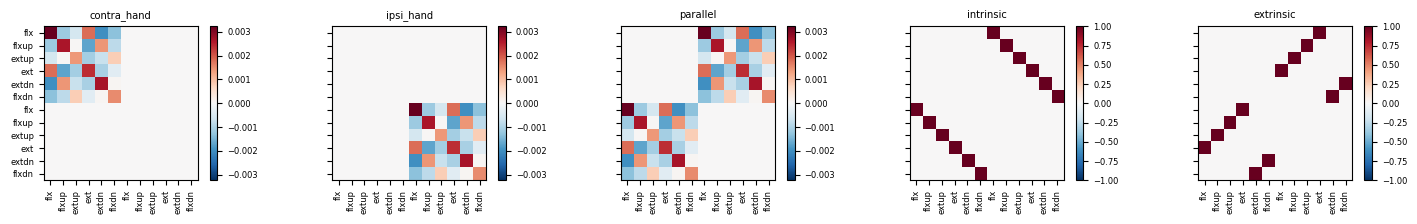

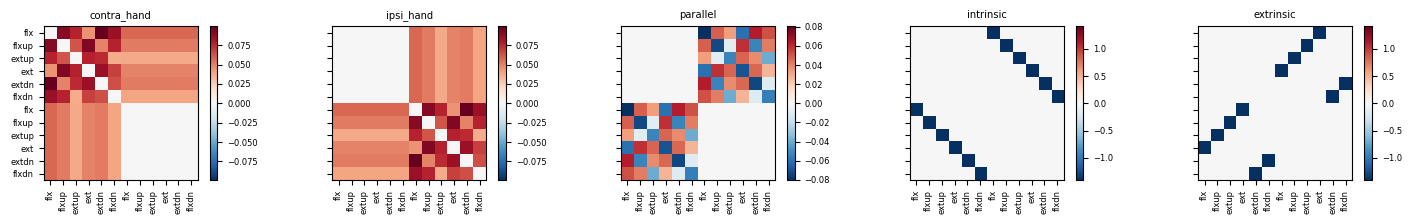

In [53]:
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn', 'flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
labels_lateral = ['contra']*6 + ['ipsi']*6
ncond = 12

M = []
modelG = {}

# Null model
cov = np.zeros((ncond, ncond))
M.append(pcm.FixedModel('null', cov))

# Contra hand structure:
ceil_fit = pd.read_pickle(os.path.join(analysisDir, f'PCM_unimanual_CVceiling_{region}.pkl'))
ceil = pcm.FreeModel('ceil',6)
params = ceil_fit['theta_cv'][0]
params = np.mean(params[0:21, :], axis=1)
G_ceil = ceil.predict(params)[0]
cov = np.zeros((ncond, ncond))
cov[0:6, 0:6] = G_ceil
# M.append(pcm.FixedModel('contra hand', cov))
modelG['contra_hand'] = [cov]

# Ipsi hand structure:
cov = np.zeros((ncond, ncond))
cov[6:12, 6:12] = G_ceil
# M.append(pcm.FixedModel('ipsi hand', cov))
modelG['ipsi_hand'] = [cov]

# Parallel contra-ipsi:
cov = np.zeros((ncond, ncond))
cov[0:6, 6:12] = G_ceil
cov[6:12, 0:6] = G_ceil
# cov = np.tile(G_ceil, (2,2))
# M.append(pcm.FixedModel('orth translation', cov))
modelG['parallel'] = [cov]

# intrinsic contra-ipsi relationship:
cov = np.zeros((ncond, ncond))
cov[0:6, 6:12] = np.eye(6)
cov[6:12, 0:6] = np.eye(6)
modelG['intrinsic'] = [cov]

# extrinsic contra-ipsi relationship:
mask_extrinsic = np.zeros((6,6)) # picking the extrinsicly similar conditions (moving to the same direction in space): e.g., flxup:extup, extdn:flxdn, ...
mask_extrinsic[0,3] = 1
mask_extrinsic[3,0] = 1
mask_extrinsic[1,2] = 1
mask_extrinsic[2,1] = 1
mask_extrinsic[4,5] = 1
mask_extrinsic[5,4] = 1
cov = np.zeros((ncond, ncond))
cov[0:6, 6:12] = mask_extrinsic
cov[6:12, 0:6] = mask_extrinsic
modelG['extrinsic'] = [cov]

# component models:
M.append(pcm.ComponentModel('orthogonal', [modelG['contra_hand'][0], modelG['ipsi_hand'][0]]))
M.append(pcm.ComponentModel('parallel', [modelG['contra_hand'][0], modelG['ipsi_hand'][0], modelG['parallel'][0]]))
M.append(pcm.ComponentModel('intrinsic', [modelG['contra_hand'][0], modelG['ipsi_hand'][0], modelG['intrinsic'][0]]))
M.append(pcm.ComponentModel('extrinsic', [modelG['contra_hand'][0], modelG['ipsi_hand'][0], modelG['extrinsic'][0]]))
M.append(pcm.ComponentModel('intrinsic+extrinsic', [modelG['contra_hand'][0], modelG['ipsi_hand'][0], modelG['intrinsic'][0], modelG['extrinsic'][0]]))

# PLOT:
n = len(modelG)
fix, ax = plt.subplots(1,n, figsize=(18,2), sharey=True)
for i in range(n):
    vmin = -np.max(np.abs(modelG[list(modelG.keys())[i]]))
    vmax = np.max(np.abs(modelG[list(modelG.keys())[i]]))
    ax[i].imshow(modelG[list(modelG.keys())[i]][0], cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i].set_title(list(modelG.keys())[i])
    ax[i].set_xticks(list(range(12)))
    ax[i].set_xticklabels(labels, rotation=90)
    ax[i].set_yticks(list(range(12)))
    ax[i].set_yticklabels(labels)
    plt.colorbar(ax[i].imshow(modelG[list(modelG.keys())[i]][0], cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i])
plt.show()

fix, ax = plt.subplots(1,n, figsize=(18,2), sharey=True)
for i in range(n):
    D = pcm.G_to_dist(modelG[list(modelG.keys())[i]][0])
    D = np.sign(D) * np.sqrt(np.abs(D))
    vmin = -np.max(np.abs(D))
    vmax = np.max(np.abs(D))
    ax[i].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i].set_title(list(modelG.keys())[i])
    ax[i].set_xticks(list(range(12)))
    ax[i].set_xticklabels(labels, rotation=90)
    ax[i].set_yticks(list(range(12)))
    ax[i].set_yticklabels(labels)
    plt.colorbar(ax[i].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i])
plt.show()




# Fit models

In [54]:
import pickle

# fit model:
T_gr, theta_gr = pcm.fit_model_group(Y, M, fixed_effect='block', fit_scale=True, verbose=True)
T_cv, theta_cv = pcm.fit_model_group_crossval(Y, M, fixed_effect='block', fit_scale=True, verbose=True)

results = {
            'T_gr': T_gr, 'theta_gr': theta_gr,
            'T_cv': T_cv, 'theta_cv': theta_cv
            }
with open(os.path.join(analysisDir, f'PCM_unimanual_{region}.pkl'), 'wb') as f:
    pickle.dump(results, f)




Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5


# Fill all regions

In [2]:
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn', 'flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
labels_lateral = ['contra']*6 + ['ipsi']*6
ncond = 12
cmap = 'RdBu_r'
sn_bad = [102, 103]
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
hem = ['L','R']

for region in regions:
    print(f'======================= processing {region} =======================')
    # =============================== BUILD DATASET ===============================
    data, cond_vec, part_vec = [], [], []
    for i_hem, h in enumerate(hem):
        roi = f'{region}_{h}'
        file_path = os.path.join(analysisDir, f'pwbeta_{roi}.npz')
        d = np.load(file_path, allow_pickle=True)

        subject = d['subject']
        indices = [k for k, s in enumerate(subject) if s not in sn_bad]

        subject = d['subject'][indices]
        cond_name_tmp = d['cond_intrinsic_vec'][indices]
        cond_vec_tmp = d['cond_num_vec'][indices]
        data_tmp = d['beta_white'][indices]
        part_tmp = d['part_vec'][indices]

        for i_sub in range(len(subject)):
            idx1 = [j for j, c in enumerate(cond_name_tmp[i_sub]) if 'rhand' in c]
            idx2 = [j for j, c in enumerate(cond_name_tmp[i_sub]) if 'lhand' in c]
            idx = idx1 + idx2
            # Y = data_tmp[i_sub][idx, :]
            Y1 = data_tmp[i_sub][idx1, :]
            Y2 = data_tmp[i_sub][idx2, :]

            # remove mean of voxels across conditions of rhand:
            rhand_parts = part_tmp[i_sub][idx1]
            for p in np.unique(rhand_parts):
                Y1[rhand_parts == p, :] = Y1[rhand_parts == p, :] - np.mean(Y1[rhand_parts == p, :], axis=0)
            # remove mean of voxels across conditions of lhand:
            lhand_parts = part_tmp[i_sub][idx2]
            for p in np.unique(lhand_parts):
                Y2[lhand_parts == p, :] = Y2[lhand_parts == p, :] - np.mean(Y2[lhand_parts == p, :], axis=0)
            Y = np.vstack((Y1, Y2))
            
            subj_part = part_tmp[i_sub][idx]
            # Sort based on Hemisphere to have contralateral first:
            if h == 'L':
                subj_cond = cond_vec_tmp[i_sub][idx]
                tmp = subj_cond.copy()
                subj_cond[tmp > 5] = tmp[tmp > 5] - 6
                subj_cond[tmp <= 5] = tmp[tmp <= 5] + 6 
            elif h == 'R':
                subj_cond = cond_vec_tmp[i_sub][idx]

            data.append(Y)
            cond_vec.append(np.array(subj_cond))
            part_vec.append(subj_part)

    Y = []
    # --- making datasets ---
    for i_sub in range(len(data)):
        obs_des = {'cond_vec': cond_vec[i_sub], 'part_vec': part_vec[i_sub]}
        Y.append(pcm.dataset.Dataset(data[i_sub], obs_descriptors=obs_des))

    # =============================== BUILD MODELS ===============================
    M = []
    modelG = {}

    # Null model
    cov = np.zeros((ncond, ncond))
    M.append(pcm.FixedModel('null', cov))

    # Contra hand structure:
    ceil_fit = pd.read_pickle(os.path.join(analysisDir, f'PCM_unimanual_CVceiling_{region}.pkl'))
    ceil = pcm.FreeModel('ceil',6)
    params = ceil_fit['theta_cv'][0]
    params = np.mean(params[0:21, :], axis=1)
    G_ceil = ceil.predict(params)[0]
    cov = np.zeros((ncond, ncond))
    cov[0:6, 0:6] = G_ceil
    # M.append(pcm.FixedModel('contra hand', cov))
    modelG['contra_hand'] = [cov]

    # Ipsi hand structure:
    cov = np.zeros((ncond, ncond))
    cov[6:12, 6:12] = G_ceil
    # M.append(pcm.FixedModel('ipsi hand', cov))
    modelG['ipsi_hand'] = [cov]

    # Parallel contra-ipsi:
    cov = np.zeros((ncond, ncond))
    cov[0:6, 6:12] = G_ceil
    cov[6:12, 0:6] = G_ceil
    # cov = np.tile(G_ceil, (2,2))
    # M.append(pcm.FixedModel('orth translation', cov))
    modelG['parallel'] = [cov]

    # intrinsic contra-ipsi relationship:
    cov = np.zeros((ncond, ncond))
    cov[0:6, 6:12] = np.eye(6)
    cov[6:12, 0:6] = np.eye(6)
    modelG['intrinsic'] = [cov]

    # extrinsic contra-ipsi relationship:
    mask_extrinsic = np.zeros((6,6)) # picking the extrinsicly similar conditions (moving to the same direction in space): e.g., flxup:extup, extdn:flxdn, ...
    mask_extrinsic[0,3] = 1
    mask_extrinsic[3,0] = 1
    mask_extrinsic[1,2] = 1
    mask_extrinsic[2,1] = 1
    mask_extrinsic[4,5] = 1
    mask_extrinsic[5,4] = 1
    cov = np.zeros((ncond, ncond))
    cov[0:6, 6:12] = mask_extrinsic
    cov[6:12, 0:6] = mask_extrinsic
    modelG['extrinsic'] = [cov]

    # component models:
    M.append(pcm.ComponentModel('orthogonal', [modelG['contra_hand'][0], modelG['ipsi_hand'][0]]))
    M.append(pcm.ComponentModel('parallel', [modelG['contra_hand'][0], modelG['ipsi_hand'][0], modelG['parallel'][0]]))
    M.append(pcm.ComponentModel('intrinsic', [modelG['contra_hand'][0], modelG['ipsi_hand'][0], modelG['intrinsic'][0]]))
    M.append(pcm.ComponentModel('extrinsic', [modelG['contra_hand'][0], modelG['ipsi_hand'][0], modelG['extrinsic'][0]]))
    M.append(pcm.ComponentModel('intrinsic+extrinsic', [modelG['contra_hand'][0], modelG['ipsi_hand'][0], modelG['intrinsic'][0], modelG['extrinsic'][0]]))

    # =============================== FIT MODELS ===============================
    
    # fit model:
    T_gr, theta_gr = pcm.fit_model_group(Y, M, fixed_effect='block', fit_scale=True, verbose=True)
    T_cv, theta_cv = pcm.fit_model_group_crossval(Y, M, fixed_effect='block', fit_scale=True, verbose=True)

    results = {
                'T_gr': T_gr, 'theta_gr': theta_gr,
                'T_cv': T_cv, 'theta_cv': theta_cv
                }
    with open(os.path.join(analysisDir, f'PCM_unimanual_{region}.pkl'), 'wb') as f:
        pickle.dump(results, f)





======================= processing M1 =======================
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

KeyboardInterrupt: 

# Plot

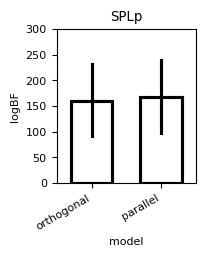

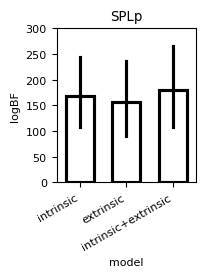

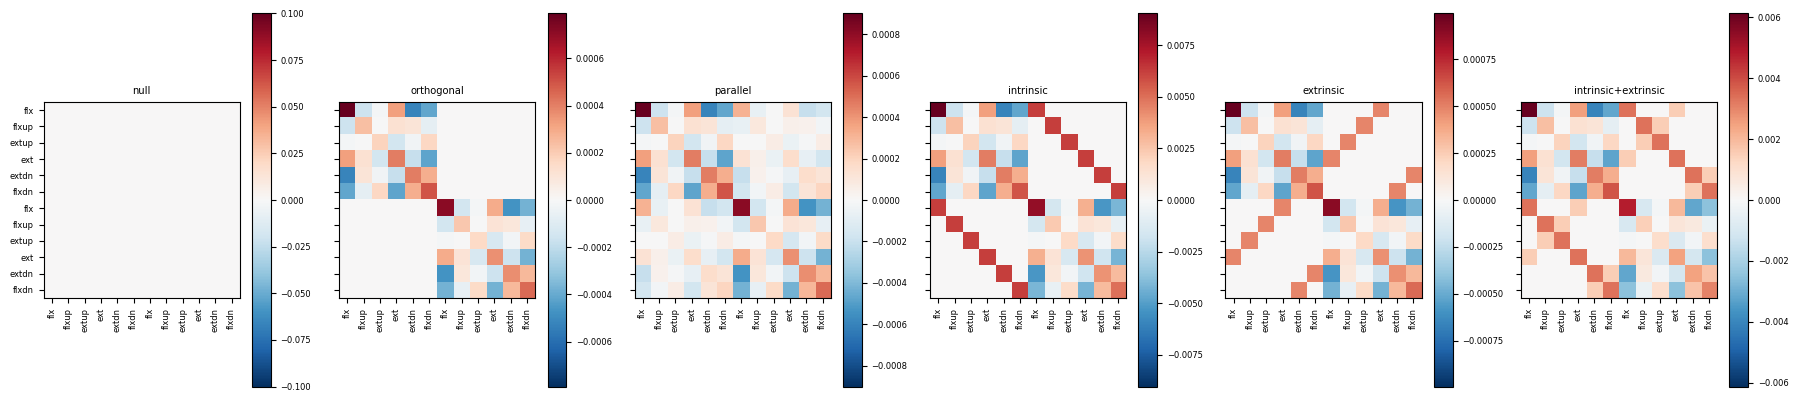

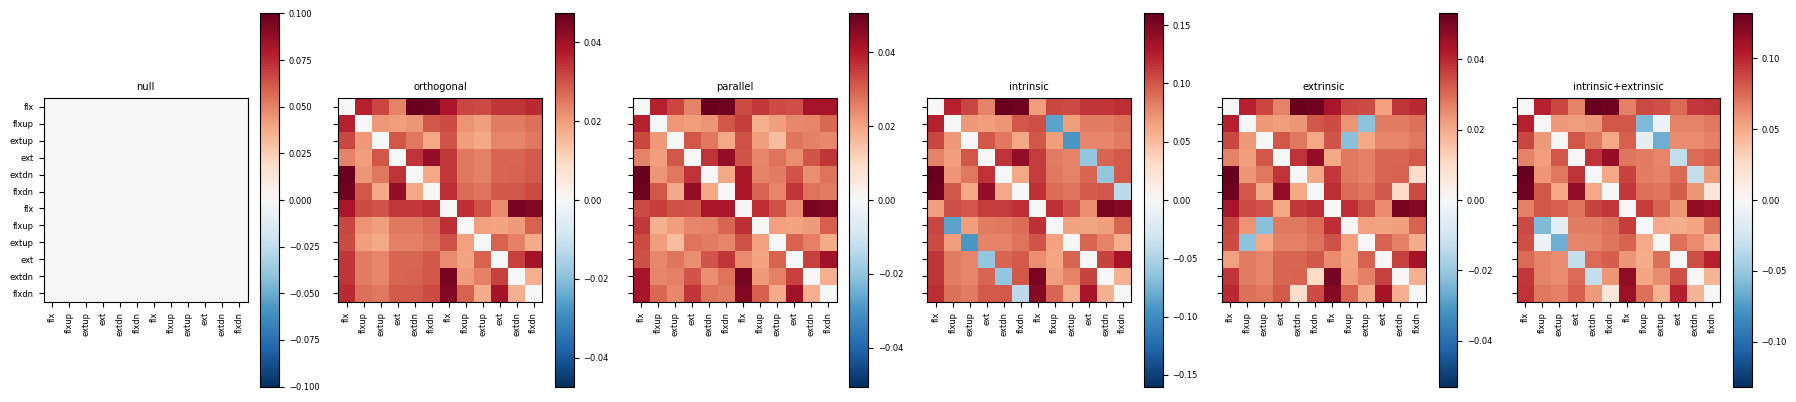

In [138]:
# load model fits:
import pickle
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
region = 'SPLp'

labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn', 'flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']

# load model fitting:
with open(os.path.join(analysisDir, f'PCM_unimanual_{region}.pkl'), 'rb') as f:
    results = pickle.load(f)

T_gr = results['T_gr']
theta_gr = results['theta_gr']
nmodels = len(theta_gr)
T_cv = results['T_cv']
theta_cv = results['theta_cv']

# =============================== BUILD MODELS ===============================
ncond = 12
M = []
modelG = {}

# Null model
cov = np.zeros((ncond, ncond))
M.append(pcm.FixedModel('null', cov))

# Contra hand structure:
ceil_fit = pd.read_pickle(os.path.join(analysisDir, f'PCM_unimanual_CVceiling_{region}.pkl'))
ceil = pcm.FreeModel('ceil',6)
params = ceil_fit['theta_cv'][0]
params = np.mean(params[0:21, :], axis=1)
G_ceil = ceil.predict(params)[0]
cov = np.zeros((ncond, ncond))
cov[0:6, 0:6] = G_ceil
# M.append(pcm.FixedModel('contra hand', cov))
modelG['contra_hand'] = [cov]

# Ipsi hand structure:
cov = np.zeros((ncond, ncond))
cov[6:12, 6:12] = G_ceil
# M.append(pcm.FixedModel('ipsi hand', cov))
modelG['ipsi_hand'] = [cov]

# Parallel contra-ipsi:
cov = np.zeros((ncond, ncond))
cov[0:6, 6:12] = G_ceil
cov[6:12, 0:6] = G_ceil
# cov = np.tile(G_ceil, (2,2))
# M.append(pcm.FixedModel('orth translation', cov))
modelG['parallel'] = [cov]

# intrinsic contra-ipsi relationship:
cov = np.zeros((ncond, ncond))
cov[0:6, 6:12] = np.eye(6)
cov[6:12, 0:6] = np.eye(6)
modelG['intrinsic'] = [cov]

# extrinsic contra-ipsi relationship:
mask_extrinsic = np.zeros((6,6)) # picking the extrinsicly similar conditions (moving to the same direction in space): e.g., flxup:extup, extdn:flxdn, ...
mask_extrinsic[0,3] = 1
mask_extrinsic[3,0] = 1
mask_extrinsic[1,2] = 1
mask_extrinsic[2,1] = 1
mask_extrinsic[4,5] = 1
mask_extrinsic[5,4] = 1
cov = np.zeros((ncond, ncond))
cov[0:6, 6:12] = mask_extrinsic
cov[6:12, 0:6] = mask_extrinsic
modelG['extrinsic'] = [cov]

# component models:
M.append(pcm.ComponentModel('orthogonal', [modelG['contra_hand'][0], modelG['ipsi_hand'][0]]))
M.append(pcm.ComponentModel('parallel', [modelG['contra_hand'][0], modelG['ipsi_hand'][0], modelG['parallel'][0]]))
M.append(pcm.ComponentModel('intrinsic', [modelG['contra_hand'][0], modelG['ipsi_hand'][0], modelG['intrinsic'][0]]))
M.append(pcm.ComponentModel('extrinsic', [modelG['contra_hand'][0], modelG['ipsi_hand'][0], modelG['extrinsic'][0]]))
M.append(pcm.ComponentModel('intrinsic+extrinsic', [modelG['contra_hand'][0], modelG['ipsi_hand'][0], modelG['intrinsic'][0], modelG['extrinsic'][0]]))

# =============================== PLOT ===============================
cmap = 'RdBu_r'
# set font:
matplotlib.rcParams.update({'font.size': 8})
fig, ax = plt.subplots(1,1,figsize=(1.8,2))
likelihood = T_cv.likelihood
baseline = likelihood.loc[:,'null'].values
likelihood = likelihood - baseline.reshape(-1,1)
likelihood = likelihood.loc[:, (likelihood.columns == 'orthogonal') | (likelihood.columns == 'parallel')]
LL = likelihood.melt(var_name='model', value_name='logBF')
sns.barplot(data=LL, x='model', y='logBF', ax=ax, fill=False, color='k', width=0.6)
plt.xticks(rotation=30, ha='right')
plt.title(f'{region}')
max_range = 300
ax.set_ylim((0, max_range))
plt.show()

fig, ax = plt.subplots(1,1,figsize=(1.8,2))
likelihood = T_cv.likelihood
baseline = likelihood.loc[:,'null'].values
likelihood = likelihood - baseline.reshape(-1,1)
likelihood = likelihood.loc[:, (likelihood.columns == 'intrinsic') | (likelihood.columns == 'extrinsic') | (likelihood.columns == 'intrinsic+extrinsic')]
LL = likelihood.melt(var_name='model', value_name='logBF')
sns.barplot(data=LL, x='model', y='logBF', ax=ax, fill=False, color='k', width=0.6)
plt.xticks(rotation=30, ha='right')
plt.title(f'{region}')
ax.set_ylim((0, max_range))
plt.show()

nmodels = len(M)
# set font:
matplotlib.rcParams.update({'font.size': 6})
# Plot model predictions:
fig, ax = plt.subplots(1, nmodels, figsize=(18,4), sharey=True)
for i in range(nmodels):
    G = M[i].predict(theta_gr[i][:M[i].n_param])[0]
    vmin = -np.max(np.abs(G))
    vmax = np.max(np.abs(G))
    ax[i].imshow(G, cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i].set_title(M[i].name)
    ax[i].set_xticks(list(range(12)))
    ax[i].set_xticklabels(labels, rotation=90)
    ax[i].set_yticks(list(range(12)))
    ax[i].set_yticklabels(labels)
    plt.colorbar(ax[i].imshow(G, cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1,nmodels, figsize=(18,4), sharey=True)
for i in range(nmodels):
    G = M[i].predict(theta_gr[i][:M[i].n_param])[0]
    D = pcm.G_to_dist(G)
    D = np.sign(D) * np.sqrt(np.abs(D))
    vmin = -np.max(np.abs(D))
    vmax = np.max(np.abs(D))
    ax[i].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i].set_title(M[i].name)
    ax[i].set_xticks(list(range(12)))
    ax[i].set_xticklabels(labels, rotation=90)
    ax[i].set_yticks(list(range(12)))
    ax[i].set_yticklabels(labels)
    plt.colorbar(ax[i].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i])
plt.tight_layout()
plt.show()




# T-Test

In [ ]:
# load model fits:
import pickle

regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
for region in regions:
    print(f'\n======================= processing {region} =======================')
    # load model fitting:
    with open(os.path.join(analysisDir, f'PCM_unimanual_{region}.pkl'), 'rb') as f:
        results = pickle.load(f)

    T_gr = results['T_gr']
    theta_gr = results['theta_gr']
    nmodels = len(theta_gr)
    T_cv = results['T_cv']
    theta_cv = results['theta_cv']

    # T-test between models:
    from scipy import stats
    likelihood = T_cv.likelihood
    m_names = likelihood.columns.values
    baseline = likelihood.loc[:,'null'].values
    likelihood = likelihood - baseline.reshape(-1,1)

    bayesfact = {'orthogonal': [], 'parallel': [], 'intrinsic': [], 'extrinsic': [], 'intrinsic+extrinsic': []}
    bayesfact['orthogonal'] = likelihood['orthogonal'].values
    bayesfact['parallel'] = likelihood['parallel'].values
    bayesfact['intrinsic'] = likelihood['intrinsic'].values
    bayesfact['extrinsic'] = likelihood['extrinsic'].values
    bayesfact['intrinsic+extrinsic'] = likelihood['intrinsic+extrinsic'].values

    # # ttest each model > 0:
    # ttests = {}
    # for k in bayesfact.keys():
    #     t, p = stats.ttest_1samp(bayesfact[k], 0, alternative='greater')
    #     mean = np.mean(bayesfact[k])
    #     std = np.std(bayesfact[k])
    #     sem = stats.sem(bayesfact[k])
    #     ttests[k] = {'t': t, 'p': p, 'dof': len(bayesfact[k])-1, 'mean': mean, 'std': std, 'sem': sem}
    #     print(f'{k}: t({ttests[k]["dof"]})={t:.2f}, p={p:.4f}, mean={mean:.2f} std={std:.2f} sem={sem:.2f}')

    # Model comparisons:
    t, p = stats.ttest_rel(bayesfact['parallel'], bayesfact['orthogonal'], alternative='greater')
    mean_diff = np.mean(bayesfact['parallel'] - bayesfact['orthogonal'])
    std_diff = np.std(bayesfact['parallel'] - bayesfact['orthogonal'])
    sem_diff = stats.sem(bayesfact['parallel'] - bayesfact['orthogonal'])
    dof = len(bayesfact['parallel']) - 1
    print('\nModel comparison:')
    print(f'parallel > orthogonal: t({dof})={t:.2f}, p={p:.4f}, mean_diff={mean_diff:.2f} std_diff={std_diff:.2f} sem_diff={sem_diff:.2f}')
    
    t, p = stats.ttest_rel(bayesfact['intrinsic+extrinsic'], bayesfact['intrinsic'], alternative='greater')
    mean_diff = np.mean(bayesfact['intrinsic+extrinsic'] - bayesfact['intrinsic'])
    std_diff = np.std(bayesfact['intrinsic+extrinsic'] - bayesfact['intrinsic'])
    sem_diff = stats.sem(bayesfact['intrinsic+extrinsic'] - bayesfact['intrinsic'])
    dof = len(bayesfact['intrinsic+extrinsic']) - 1
    print(f'intrinsic+extrinsic > intrinsic: t({dof})={t:.2f}, p={p:.4f}, mean_diff={mean_diff:.2f} std_diff={std_diff:.2f} sem_diff={sem_diff:.2f}')

    t, p = stats.ttest_rel(bayesfact['intrinsic+extrinsic'], bayesfact['extrinsic'], alternative='greater')
    mean_diff = np.mean(bayesfact['intrinsic+extrinsic'] - bayesfact['extrinsic'])
    std_diff = np.std(bayesfact['intrinsic+extrinsic'] - bayesfact['extrinsic'])
    sem_diff = stats.sem(bayesfact['intrinsic+extrinsic'] - bayesfact['extrinsic'])
    dof = len(bayesfact['intrinsic+extrinsic']) - 1
    print(f'intrinsic+extrinsic > extrinsic: t({dof})={t:.2f}, p={p:.4f}, mean_diff={mean_diff:.2f} std_diff={std_diff:.2f} sem_diff={sem_diff:.2f}')

    t, p = stats.ttest_rel(bayesfact['intrinsic'], bayesfact['extrinsic'], alternative='two-sided')
    mean_diff = np.mean(bayesfact['intrinsic'] - bayesfact['extrinsic'])
    std_diff = np.std(bayesfact['intrinsic'] - bayesfact['extrinsic'])
    sem_diff = stats.sem(bayesfact['intrinsic'] - bayesfact['extrinsic'])
    dof = len(bayesfact['intrinsic']) - 1
    print(f'intrinsic != extrinsic: t({dof})={t:.2f}, p={p:.4f}, mean_diff={mean_diff:.2f} std_diff={std_diff:.2f} sem_diff={sem_diff:.2f}')

    t, p = stats.ttest_rel(bayesfact['parallel'], bayesfact['intrinsic+extrinsic'], alternative='greater')
    mean_diff = np.mean(bayesfact['parallel'] - bayesfact['intrinsic+extrinsic'])
    std_diff = np.std(bayesfact['parallel'] - bayesfact['intrinsic+extrinsic'])
    sem_diff = stats.sem(bayesfact['parallel'] - bayesfact['intrinsic+extrinsic'])
    dof = len(bayesfact['parallel']) - 1
    print(f'parallel > intrinsic+extrinsic: t({dof})={t:.2f}, p={p:.4f}, mean_diff={mean_diff:.2f} std_diff={std_diff:.2f} sem_diff={sem_diff:.2f}')




======================= processing M1 =======================

Model comparison:
parallel > orthogonal: t(23)=0.50, p=0.3098, mean_diff=1.10 std_diff=10.52 sem_diff=2.19
intrinsic+extrinsic > intrinsic: t(23)=1.17, p=0.1266, mean_diff=3.33 std_diff=13.62 sem_diff=2.84
intrinsic+extrinsic > extrinsic: t(23)=1.37, p=0.0919, mean_diff=4.36 std_diff=15.26 sem_diff=3.18
intrinsic != extrinsic: t(23)=0.23, p=0.8213, mean_diff=1.03 std_diff=21.68 sem_diff=4.52
parallel > intrinsic+extrinsic: t(23)=1.42, p=0.0841, mean_diff=3.58 std_diff=12.06 sem_diff=2.52
======================= processing S1 =======================

Model comparison:
parallel > orthogonal: t(23)=0.38, p=0.3555, mean_diff=0.79 std_diff=10.10 sem_diff=2.11
intrinsic+extrinsic > intrinsic: t(23)=1.00, p=0.1635, mean_diff=5.17 std_diff=24.77 sem_diff=5.16
intrinsic+extrinsic > extrinsic: t(23)=1.23, p=0.1149, mean_diff=5.72 std_diff=22.24 sem_diff=4.64
intrinsic != extrinsic: t(23)=0.07, p=0.9444, mean_diff=0.55 std_diff=37.26 

# Save ceiling for each region

In [40]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']

for region in regions:
    # load model fits:
    with open(os.path.join(analysisDir, f'PCM_unimanual_{region}.pkl'), 'rb') as f:
        results = pickle.load(f)

    T_gr = results['T_gr']
    theta_gr = results['theta_gr']
    nmodels = len(theta_gr)
    T_cv = results['T_cv']
    theta_cv = results['theta_cv']

    ceil_gr = T_gr.likelihood['ceil'].reset_index(drop=True)
    ceil_cv = T_cv.likelihood['ceil'].reset_index(drop=True)
    theta_gr = theta_gr[-1]
    theta_cv = theta_cv[-1]

    ceil = {
                'T_gr': T_gr, 'theta_gr': theta_gr,
                'T_cv': T_cv, 'theta_cv': theta_cv
                }
    with open(os.path.join(analysisDir, f'PCM_unimanual_ceil_{region}.pkl'), 'wb') as f:
        pickle.dump(ceil, f)

